### Comparing Models

Now that you have seen a variety of models for regression and classification problems, it is good to step back and weigh the pros and cons of these options.  In the case of classification models, there are at least three things to consider:

1. Is the model good at handling imbalanced classes?
2. Does the model train quickly?
3. Does the model yield interpretable results?

Depending on your dataset and goals, the importance of these considerations will vary from project to project.  Your goal is to review our models to this point and discuss the pros and cons of each.  Two example datasets are offered as a way to offer two very different tasks where interpretability of the model may be of differing importance.

### Data and Task

Your goal is to discuss the pros and cons of Logistic Regression, Decision Trees, KNN, and SVM for the tasks below.  Consider at least the three questions above and list any additional considerations you believe are important to determining the "best" model for the task.  Share your response with your peers on the class discussion board.  

**TASK 1**: Predicting Customer Churn

Suppose you are tasked with producing a model to predict customer churn.  Which of your classification models would you use and what are the pros and cons of this model for this task?  Be sure to consider interpretability, imbalnced classes, and the speed of training.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
from sklearn.datasets import load_digits

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The data is loaded below.  Note that the handwritten digit data is already split into features and target (`digits`, `labels`).

In [10]:

   churn = pd.read_csv('/content/drive/MyDrive/MLAI_Haas/data/telecom_churn.csv')
   digits, labels = load_digits(return_X_y=True)

In [11]:
#churn data
churn.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [58]:
from sklearn.model_selection import train_test_split

X = churn.drop('Churn', axis=1)
y = churn['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [59]:
#Check the imbalance of the target variable and print the normalized value counts
print(y.value_counts(normalize=True))

Churn
False    0.855086
True     0.144914
Name: proportion, dtype: float64


In [62]:
#Apply OneHotEncoder to categorical columns
#Apply StandardScaler to numerical columns
#Use 'Area code' as a categorical column
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score

#Create a list of categorical columns
categorical_columns = ['State', 'International plan', 'Voice mail plan', 'Area code']

#Treat the rest of columns as numerical
numerical_columns = list(set(X.columns) - set(categorical_columns))

#Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ]
)

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_auc_score
import time
import pandas as pd

def evaluate_model(name, pipeline, X_train, y_train, X_test, y_test):
    start = time.time()
    pipeline.fit(X_train, y_train)
    end = time.time()
    time_taken = round(end - start, 4)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    interpretability = hasattr(pipeline.named_steps['classifier'], 'coef_') or hasattr(pipeline.named_steps['classifier'], 'feature_importances_')
    handles_imbalance = roc_auc > 0.8 and test_recall > 0.7
    overfitting = train_f1 > test_f1
    return [name, test_accuracy, test_recall, test_f1, roc_auc]

models = {
    "Logistic Regression": Pipeline([('preprocessor', preprocessor), ('classifier', LogisticRegression(class_weight='balanced'))]),
    "Decision Tree": Pipeline([('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(class_weight='balanced'))]),
    "KNN": Pipeline([('preprocessor', preprocessor), ('classifier', KNeighborsClassifier())]),
    "SVM sigmoid kernel": Pipeline([('preprocessor', preprocessor), ('classifier', SVC(kernel='sigmoid', class_weight='balanced'))]),
    "SVM RBF kernel": Pipeline([('preprocessor', preprocessor), ('classifier', SVC(kernel='rbf', class_weight='balanced'))])
}

results = []

for name, pipeline in models.items():
    results.append(evaluate_model(name, pipeline, X_train, y_train, X_test, y_test))

df = pd.DataFrame(results, columns=['Model', 'Test Accuracy', 'Test Recall', 'Test F1', 'AUC-ROC'])
df.sort_values(by=['Test Recall'], ascending=False)

,Model,Test Accuracy,Test Recall,Test F1,AUC-ROC
0,Logistic Regression,0.779,0.790210,0.505593,0.783670
4,SVM RBF kernel,0.909,0.755245,0.703583,0.844950
1,Decision Tree,0.921,0.720280,0.722807,0.837386
3,SVM sigmoid kernel,0.523,0.587413,0.260465,0.549832
2,KNN,0.885,0.223776,0.357542,0.609554


**TASK 2**: Recognizing Handwritten Digits

Suppose you are tasked with training a model to recognize handwritten digits.  Which of your classifier would you use here and why?  Again, be sure to consider the balance of classes, speed of training, and importance of interpretability.



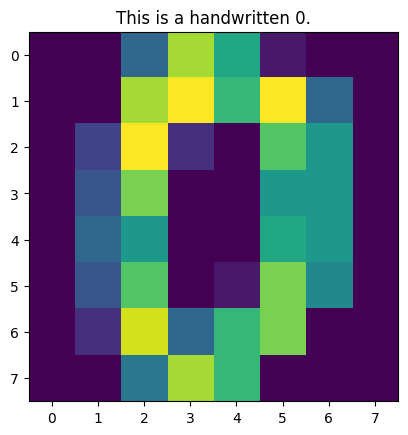

In [71]:
#example image
plt.imshow(digits[0].reshape(8, 8))
plt.title('This is a handwritten 0.');

In [72]:
#print the distribution of values in the digits.target variable in ascending order in normalized form
print(pd.Series(labels).value_counts(normalize=True).sort_index())

0    0.099054
1    0.101280
2    0.098497
3    0.101836
4    0.100723
5    0.101280
6    0.100723
7    0.099610
8    0.096828
9    0.100167
Name: proportion, dtype: float64


In [73]:
!pip install --upgrade scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_auc_score
import time

In [74]:
# Split the data into training and test sets
#X_digits_train, X_digits_test, y_digits_train, y_digits_test = train_test_split(digits.data, labels, test_size=0.2, random_state=42)

X_digits_train, X_digits_test, y_digits_train, y_digits_test = train_test_split(
    np.asarray(digits.data), labels, test_size=0.2, random_state=42
)

#print the distribution of values in the digits.target variable in ascending order in normalized form
#print(pd.Series(labels).value_counts(normalize=True).sort_index())


# Preprocessing: Standardize features by removing the mean and scaling to unit variance
preprocessor = StandardScaler()



In [75]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, f1_score

def evaluate_model(name, pipeline, X_train, y_train, X_test, y_test):
    start = time.time()
    pipeline.fit(X_train, y_train)
    end = time.time()
    time_taken = round(end - start, 4)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    interpretability = hasattr(pipeline.named_steps['classifier'], 'coef_') or hasattr(pipeline.named_steps['classifier'], 'feature_importances_')
    overfitting = train_accuracy > test_accuracy
    return [name, test_accuracy, test_precision, test_f1]

models = {
    "Logistic Regression": Pipeline([('preprocessor', preprocessor), ('classifier', LogisticRegression())]),
    "Decision Tree": Pipeline([('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier())]),
    "KNN": Pipeline([('preprocessor', preprocessor), ('classifier', KNeighborsClassifier())]),
    "SVM linear kernel": Pipeline([('preprocessor', preprocessor), ('classifier', SVC(kernel='linear'))]),
    "SVM poly kernel": Pipeline([('preprocessor', preprocessor), ('classifier', SVC(kernel='poly'))]),
}

y_digits_train = y_digits_train.reshape(-1)
y_digits_test = y_digits_test.reshape(-1)

results = []

for name, pipeline in models.items():
    results.append(evaluate_model(name, pipeline, X_digits_train, y_digits_train, X_digits_test, y_digits_test))

df = pd.DataFrame(results, columns=['Model', 'Test Accuracy', 'Avg Test Precision', 'Avg Test F1'])
df.sort_values(by=['Avg Test Precision'], ascending=False)

,Model,Test Accuracy,Avg Test Precision,Avg Test F1
3,SVM linear kernel,0.975000,0.975265,0.974957
2,KNN,0.975000,0.975015,0.974780
0,Logistic Regression,0.972222,0.972521,0.972296
4,SVM poly kernel,0.963889,0.971801,0.965707
1,Decision Tree,0.850000,0.855063,0.849498
